In [1]:
%matplotlib inline
%load_ext pycodestyle_magic
%flake8_on

In [2]:
import pyro
import torch
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyro.distributions as dist
from ldavi import bbvi
from torch.distributions.constraints import positive
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import ClippedAdam
from nltk.corpus import stopwords
import importlib
importlib.reload(bbvi)
stopwords = set(stopwords.words('english'))

http://proceedings.mlr.press/v32/tang14.pdf

Load and preprocess data

In [3]:
import process_data
importlib.reload(process_data)

data_all = process_data.load_process()

FileNotFoundError: [Errno 2] No such file or directory: '.\\data\\product_name.csv'

In [327]:
import util
import importlib
importlib.reload(util)

orders_path = os.path.join("data", "order_products__train.csv")
products_path = os.path.join("data", "products.csv")
o, data_raw = process_data.load_process(orders_path, products_path)

plt.figure(figsize=(3, 5))
o["shortname"].value_counts().head(20).iloc[::-1].plot(kind="barh")

ValueError: too many values to unpack (expected 2)

In [27]:
from ldavi import bbvi
import importlib
importlib.reload(bbvi)

data = data_raw.head(10)
params = {"lr": 0.005, "betas": (0.95, 0.999)}
bbvi = bbvi.LDABBVI(data, ClippedAdam, optimizer_params=params, n_topics=5)
loss = bbvi.run_svi(n_steps=100, num_particles=1, clear_params=True)

plt.figure(figsize=(10,4))
plt.plot(loss), plt.plot(pd.Series(loss).rolling(50).mean())

0% (4192.6) | 5% (4266.8) | 10% (4172.3) | 15% (4152.2) | 20% (4055.7) | 25% (4193.8) | 30% (4137.0) | 35% (4134.0) | 40% (4179.1) | 45% (4080.9) | 

KeyboardInterrupt: 

7:80: E501 line too long (80 > 79 characters)
10:23: E231 missing whitespace after ','


#### MC Integration Analysis

When computing the ELBO gradient at each step, we are trying to estimate a quantity of the following form:

$$\nabla_{\phi}\mathbb{E}_{q_{\phi}({\bf z})} \left [f_{\phi}({\bf z}) \right]$$

Before we can move the $\nabla$ into the expectation, we need to remove the dependency of $q(z)$ on $\phi$. This can be done by reparametrization, which is easy for LDA because the PDF of dirichlet and categorical are continuous w.r.t. their parameters.

$$\nabla_{\phi}\mathbb{E}_{q({\bf \epsilon})} \left [f_{\phi}(g_{\phi}({\bf \epsilon})) \right]=
\mathbb{E}_{q({\bf \epsilon})} \left [\nabla_{\phi}f_{\phi}(g_{\phi}({\bf \epsilon})) \right]$$

The issue, however, is that the number of latent variables $z_{d,w}$ grows linearly with number of observations, and usually we need at least tens of thousands of observation to obtain sensible results. This greatly increases the variance of the MC integration estimate. In the next few cells, we will demonstrate with a toy example how high-dimensional support for $q(z)$ can affect the variance of the estimate.

$$\mathbb{E}_{q(z)}[f(z)] \approx \frac{1}{S}\sum^S_i f(z_i) \text{ where } f(z) = z^2$$

2 5 100 300 600 1000 

Text(0.5, 0, 'Dimension of z')

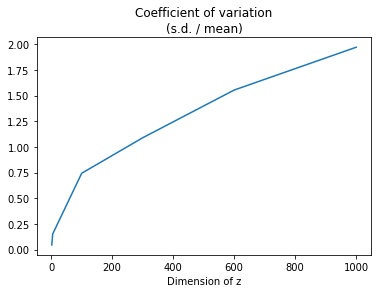

In [44]:
import util
import importlib
importlib.reload(util)


def func(x):
    return x**2


q = dist.Dirichlet
num_params = [2, 5, 100, 300, 600, 1000]
exponent = 1
n_trials = 100
n_samples = 500
stds = []
for num_param in num_params:
    print(num_param, end=' ')
    param = torch.FloatTensor(abs(np.random.randn(num_param))**exponent)
    param /= param.sum()
    means = util.mc(q(param), func, n_trials=n_trials, n_samples=n_samples)
    std_adj = (means.std(0) / (means.mean(0) + 1e-15)).mean()
    stds.append(std_adj)

plt.plot(num_params, stds)
plt.title('Coefficient of variation\n(s.d. / mean)')
plt.xlabel('Dimension of z')

2 5 100 300 600 1000 

Text(0.5, 0, 'Dimension of z')

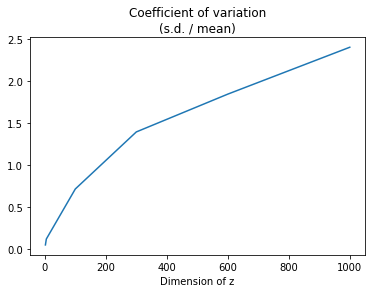

In [45]:
def func(x):
    return x**3


q = dist.Dirichlet
num_params = [2, 5, 100, 300, 600, 1000]
exponent = 1
n_trials = 100
n_samples = 500
stds = []
for num_param in num_params:
    print(num_param, end=' ')
    param = torch.FloatTensor(abs(np.random.randn(num_param))**exponent)
    param /= param.sum()
    means = util.mc(q(param), func, n_trials=n_trials, n_samples=n_samples)
    std_adj = (means.std(0) / (means.mean(0) + 1e-15)).mean()
    stds.append(std_adj)

plt.plot(num_params, stds)
plt.title('Coefficient of variation\n(s.d. / mean)')
plt.xlabel('Dimension of z')

In [272]:
DIM = 10
SHIFT = np.random.randn(DIM) ** 2
SCALE = np.random.randn(DIM) ** 4


def f(x):
    output = np.power(x * SCALE + SHIFT, 4)
    return output.sum()


def df(x):
    output = 2 * x * SCALE
    return output.sum()

In [290]:
from scipy.spatial.transform import Rotation as R

R.random().as_matrix()

array([[ 0.04291204, -0.78255826, -0.62109672],
       [ 0.80813415,  0.39271408, -0.43897022],
       [ 0.58743319, -0.48309236,  0.64926421]])

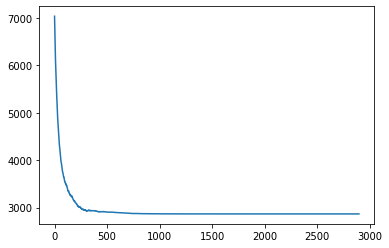

In [273]:
x = np.random.randn(DIM)
lr = 0.001
decay = 0.995
n_steps = 3000
res = []
for step in range(n_steps):
    noisy_grad = df(x) + np.random.randn()
    x -= lr * noisy_grad
    lr *= decay
    res.append(f(x))
plt.plot(res[100:])

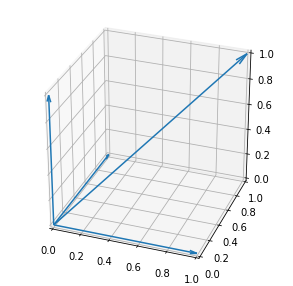

7:28: E231 missing whitespace after ','


In [195]:
from mpl_toolkits.mplot3d import Axes3D

soa = np.array([[0, 0, 0, 1, 1, 1], [0, 0, 0, 0, 0, 1],
                [0, 0, 0, 0, 1, 0], [0, 0, 0, 1, 0, 0]])

X, Y, Z, U, V, W = zip(*soa)
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')
ax.quiver(X, Y, Z, U, V, W, length=1, arrow_length_ratio=0.05)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_zlim([0, 1])
ax.view_init(30, -70)
plt.show()

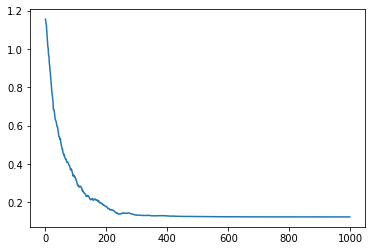

In [78]:
def f(x):
    return np.power(x, 2)


def df(x):
    return 2 * x


x = np.random.randn(1)
lr = 0.01
decay = 0.99
n_steps = 1000
norms = []
for step in range(n_steps):
    noisy_grad = df(x) + np.random.randn()
    x -= lr * noisy_grad
    lr *= decay
    norms.append(np.linalg.norm(x))
plt.plot(norms)